Example of RAG with Agent which retrieves info from different vector databases for different purposes

What it does - 

    Takes the query in goes to the vector database that it thinks is perfect for the query 
    If the retrieved documents from the database doesn't match that of the query - which is checked by another agent - then it reinitiates the process again and checks another relevant database for documents and reasoning

In [1]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

/Users/maruthienugula/RAG_learnings/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
urls=[
    "https://docs.langchain.com/oss/python/langgraph/overview",
    "https://docs.langchain.com/oss/python/langgraph/workflows-agents",
    "https://docs.langchain.com/oss/python/langgraph/graph-api#map-reduce-and-the-send-api"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/overview', 'title': 'LangGraph overview - Docs by LangChain', 'description': 'Gain control with LangGraph to design agents that reliably handle complex tasks', 'language': 'en'}, page_content='LangGraph overview - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangGraph overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartLocal serverChangelogThinking in LangGraphWorkflows + agentsCapabilitiesPersistenceDurable executionStreamingInterruptsTime travelMemorySubgraphsProductionApplication structureTestLangSmith StudioAgent Chat UILangSmith DeploymentLangSmith ObservabilityLangGraph APIsGraph APIFunctional APIRuntimeOn this page InstallCore benefitsLangGraph ecosystemAcknowledgementsLangGraph overviewCopy pageGain control with LangGraph to design

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)
embeddings

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ca440751-37ed-4c35-9b11-b668c53144d1)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 16ce44ae-9f19-4953-a22a-9f89640c4653)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/./modules.json
Retrying in 2s [Retry 2/5].


HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [ ]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)


## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings #huggingface
)


retriever=vectorstore.as_retriever()

In [8]:
retriever.invoke("what is langgraph")

[Document(id='1843b64c-a090-4762-97d1-0740e2a49a9f', metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/overview', 'title': 'LangGraph overview - Docs by LangChain', 'description': 'Gain control with LangGraph to design agents that reliably handle complex tasks', 'language': 'en'}, page_content='LangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.\nWe will commonly use LangChain components throughout the documentation to integrate models and tools, but you don’t need to use LangChain to use LangGraph. If you are just getting started with agents or want a higher-level abstraction, we recommend you use LangChain’s agents that provide pre-built architectures for common LLM and tool-calling loops.\nLangGraph is focused on the underlying capabilities important for agent orchestration: durable execution, streami

In [29]:
def docs_to_text(docs):
    """
    Convert whatever `docs` is into a plain text string safe to pass to LLMs / Groq.
    Accepts:
      - list[Document] (LangChain Document)
      - single Document
      - already a str
      - list[str]
    Returns a joined string.
    """
    if docs is None:
        return ""
    # already a string
    if isinstance(docs, str):
        return docs
    # list-like
    try:
        # handle list of Document or list of strings
        if isinstance(docs, (list, tuple)):
            parts = []
            for d in docs:
                if hasattr(d, "page_content"):
                    parts.append(
                        f"Source: {getattr(d, 'metadata', {}).get('source','unknown')}\n{d.page_content}"
                    )
                else:
                    parts.append(str(d))
            return "\n\n---\n\n".join(parts)
    except Exception:
        pass
    # single Document-like object
    if hasattr(docs, "page_content"):
        return f"Source: {getattr(docs, 'metadata', {}).get('source','unknown')}\n{docs.page_content}"
    # fallback
    return str(docs)


# Wait a minute ----------
## The first graph.invoke  below didn't work - because it is retrieving document but groq expects json type or string type ,etc
### but this code work absolutely fine

# Retriever To Retriever Tools
from langchain_core.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

### Langchain Blogs- Seperate Vector Store

In [11]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'LangChain overview - Docs by LangChain', 'description': 'LangChain is an open source framework with a pre-built agent architecture and integrations for any model or tool — so you can build agents that adapt as fast as the ecosystem evolves', 'language': 'en'}, page_content='LangChain overview - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChain overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartChangelogPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewBuilt-in middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engineeringModel Context Protocol (MCP)Human-in-the-loopMulti-agentRetrievalLong-term memoryAgent developmentLangSmith StudioTestAgent Chat UI

In [12]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstorelangchain=FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings
)


retrieverlangchain=vectorstorelangchain.as_retriever()

In [53]:
from langchain_core.callbacks import CallbackManagerForRetrieverRun

In [54]:
from langchain.tools import tool  # or the tool decorator available in your env

@tool("retriever_vector_db_blog", description="Search and run information about Langgraph", return_direct=True)
def retriever_vector_db_blog_tool(query: str) -> str:
    # Use the retriever you already created `retriever`
    docs = retriever._get_relevant_documents(query,run_manager=CallbackManagerForRetrieverRun.get_noop_manager())
    return docs_to_text(docs)


@tool("retriever_vector_langchain_blog", description="Search and run information about Langchain", return_direct=True)
def retriever_vector_langchain_blog_tool(query: str) -> str:
    docs = retrieverlangchain._get_relevant_documents(query,run_manager=CallbackManagerForRetrieverRun.get_noop_manager())
    return docs_to_text(docs)


# ---------------------------

from langchain_core.tools.retriever import create_retriever_tool

retriever_tool_langchain=create_retriever_tool(
    retrieverlangchain,
    "retriever_vector_langchain_blog",
    "Search and run information about Langchain"
)

In [55]:
tools = [retriever_vector_db_blog_tool, retriever_vector_langchain_blog_tool]

LangGraph Workflow

In [56]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [57]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama-3.3-70b-versatile")
llm.invoke("what are the characteristic changes in tony stark after the infinity war ?")

AIMessage(content="After Avengers: Infinity War, Tony Stark (a.k.a. Iron Man) undergoes significant character development and change. Here are some of the key changes:\n\n1. **Trauma and Guilt**: The failure to stop Thanos and the subsequent snap that wipes out half of all life in the universe leaves Tony with deep emotional scars. He feels guilty for not being able to prevent the catastrophe and is haunted by the memories of his friends and allies who were dusted.\n2. **Desperation and Obsession**: Tony becomes increasingly desperate to find a way to undo the damage and restore balance to the universe. He becomes obsessed with finding a solution, which leads him to spend countless hours researching and experimenting, often to the point of exhaustion.\n3. **Loss of Confidence**: The events of Infinity War shake Tony's confidence in his abilities and his role as a hero. He begins to question whether he's truly made a difference and whether his actions have been effective in protecting t

In [58]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = init_chat_model("groq:llama-3.3-70b-versatile")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [59]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [60]:
# Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = init_chat_model("groq:llama-3.3-70b-versatile")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content
    context_text = docs_to_text(docs)
    scored_result = chain.invoke({"question": question, "context": context_text})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [61]:

import os
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
from langsmith import Client

client = Client()

In [62]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = client.pull_prompt("rlm/rag-prompt")

    # LLM
    llm = init_chat_model("groq:llama-3.3-70b-versatile")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    context_text = docs_to_text(docs)
    # Run
    response = rag_chain.invoke({"context": context_text, "question": question})
    return {"messages": [response]}

In [63]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = init_chat_model("groq:llama-3.3-70b-versatile")
    response = model.invoke(msg)
    return {"messages": [response]}

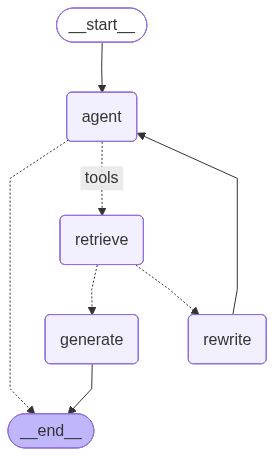

In [64]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_vector_db_blog_tool, retriever_vector_langchain_blog_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
graph.invoke({"messages":"What is Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langgraph?', additional_kwargs={}, response_metadata={}, id='ebcf03e4-e08e-4458-9182-f269cb96d6ba'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'k14a3x2cv', 'function': {'arguments': '{"query":"What is Langgraph?"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 290, 'total_tokens': 311, 'completion_time': 0.049929921, 'completion_tokens_details': None, 'prompt_time': 0.016570348, 'prompt_tokens_details': None, 'queue_time': 0.058346501, 'total_time': 0.066500269}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c29d9-673e-7b50-81c0-0394adb8d1d7-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'What is Langgraph?'}, 'id': 'k14a3x2cv', 'type': 'tool_call'}], inv

In [68]:
graph.invoke({"messages":"What is Machine learning?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine learning?', additional_kwargs={}, response_metadata={}, id='72de6188-8f32-4830-889d-d12275bc2c56'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7948am9rg', 'function': {'arguments': '{"query":"Machine learning definition and overview"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 290, 'total_tokens': 312, 'completion_time': 0.068596533, 'completion_tokens_details': None, 'prompt_time': 0.014637893, 'prompt_tokens_details': None, 'queue_time': 0.048266666, 'total_time': 0.083234426}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c29dd-156b-7f53-9828-949537c53689-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Machine learning definition and overvi

Just used for debugging
The first .invoke didn't work - because it is retrieving document but groq expects json type or string type ,etc

In [40]:
for tool in tools:
    print(tool.name)
    print(tool.args_schema.schema())


retriever_vector_db_blog
{'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'retriever_vector_db_blog', 'type': 'object'}
retriever_vector_langchain_blog
{'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'retriever_vector_langchain_blog', 'type': 'object'}


/var/folders/qt/64kxbqr16ps6hbrf1lzxq5dc0000gn/T/ipykernel_61468/4242904539.py:3: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  print(tool.args_schema.schema())
